# Correr, el ejercicio más completo - C312

Integrantes:
- David Lezcano Becerra
- Alfredo Nuño Oquendo

## Cargar los datos

In [3]:
import pandas as pd

# Ruta del primer archivo CSV
file_path = '../simulation_results/simple_carwash_simulation.csv' 
# Cargar el segundo archivo CSV en otro DataFrame
df = pd.read_csv(file_path)

# Concatenar df2 al final de df1

# Seleccionar todas las columnas excepto 'TrackerDistance', 'Date' y 'LoggedActivitiesDistance'
# df = df.drop(columns=['SedentaryActiveDistance', 'SedentaryMinutes', 'Unnamed: 0'])

# # Identificar las filas donde 'TotalSteps' es igual a 0 porque no nos interesan las personas que no corrieron nada
# rows_to_drop = df[df['TotalSteps'] == 0].index

# # Eliminar esas filas del DataFrame
# df = df.drop(rows_to_drop)

# Obtener los nombres de las columnas como un array
column_names = df.columns.to_list()
df

,duration,service_usage,lost_cars,mean_delay_time,effective_interarrival_mean
0,36000,36000,143,4541.409091,526.000000
1,36000,36000,130,4996.885246,589.333333
2,36000,35819,170,4214.971429,503.043478
3,36000,35971,147,4886.147541,594.283333
4,36000,35613,110,4925.466667,603.033898
...,...,...,...,...,...
995,36000,35997,165,6022.803922,690.980000
996,36000,35614,141,5864.901961,642.940000
997,36000,35845,125,4987.262295,578.933333
998,36000,36000,123,4866.672131,594.900000


In [4]:
import pandas as pd

pd.set_option('display.float_format', '{:.3f}'.format)
df.describe()

,duration,service_usage,lost_cars,mean_delay_time,effective_interarrival_mean
count,1000.000,1000.000,1000.000,1000.000,1000.000
mean,36000.000,35849.054,141.180,5143.117,610.675
std,0.000,223.141,15.606,672.968,73.610
min,36000.000,34596.000,90.000,3567.412,446.167
25%,36000.000,35777.000,131.000,4648.258,556.308
50%,36000.000,35946.500,141.000,5082.186,605.593
75%,36000.000,36000.000,152.000,5535.541,652.585
max,36000.000,36000.000,194.000,8001.077,941.789


## Mostrar histograma con los datos

/home/david/bin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


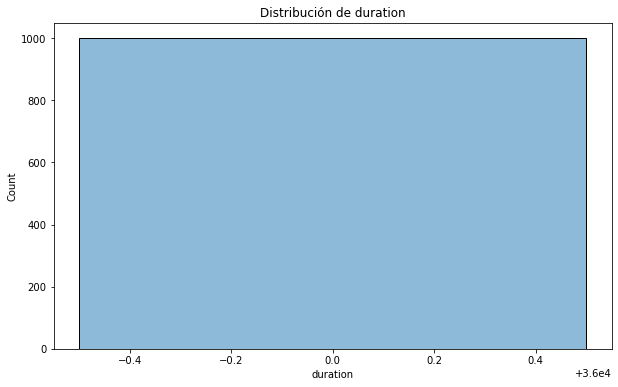

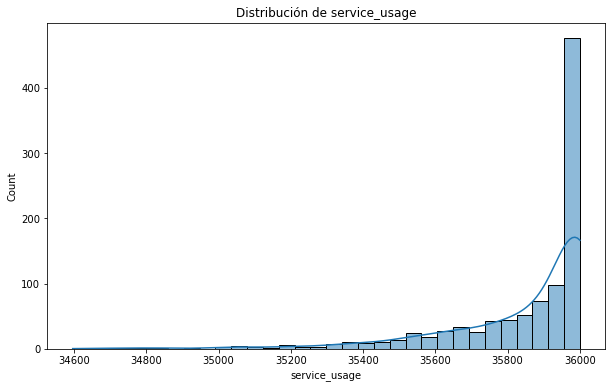

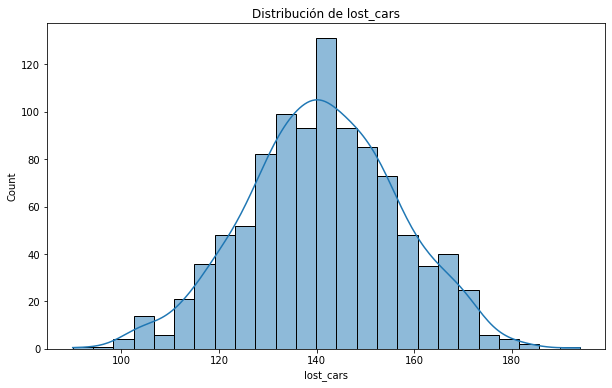

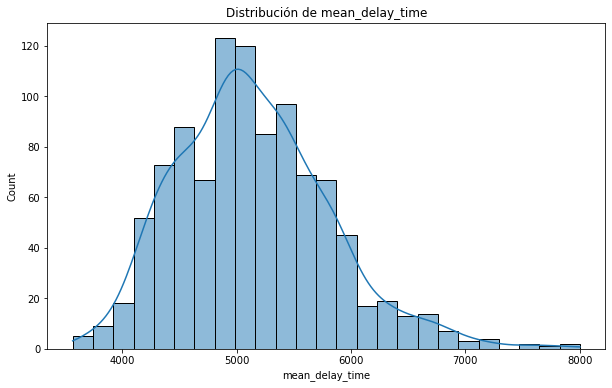

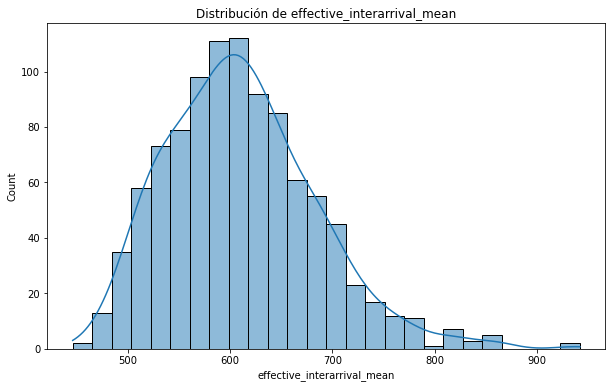

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# Asegúrate de que 'df' es tu DataFrame
for column in df.columns:
    plt.figure(figsize=(10, 6)) # Ajusta el tamaño de la figura
    sns.histplot(df[column], kde=True) # Crea un histograma con una línea de densidad
    plt.title(f'Distribución de {column}') # Título del gráfico
    plt.show() # Muestra el gráfico

Como podemos apreciar, ninguna de nuestras variables tiene un comportamiento normal

## Análisis de normalidad

In [6]:
for x in df.columns:
    print(f"El kurtosis de {x} es {df[x].kurtosis()}")
    print(f"La Asimetría de {x} es {df[x].skew()}")

El kurtosis de duration es 0
La Asimetría de duration es 0
El kurtosis de service_usage es 5.6633049952745615
La Asimetría de service_usage es -2.1799445556045853
El kurtosis de lost_cars es -0.07182824189787507
La Asimetría de lost_cars es -0.046418789282377367
El kurtosis de mean_delay_time es 0.7718912350489253
La Asimetría de mean_delay_time es 0.6275366126202778
El kurtosis de effective_interarrival_mean es 0.8734054191407248
La Asimetría de effective_interarrival_mean es 0.6789742439205045


- Columnas con alta curtosis y asimetría positiva o negativa: Estas columnas (VeryActiveDistance, ModeratelyActiveDistance, VeryActiveMinutes, FairlyActiveMinutes) probablemente tienen distribuciones que son menos normales. Podrían tener colas pesadas y valores atípicos, lo que podría afectar el rendimiento de ciertos métodos estadísticos que asumen normalidad.
- Columnas con baja curtosis y asimetría cercana a cero: Estas columnas (LightActiveDistance, LightlyActiveMinutes, Calories, TotalMinutes, Velocidad) parecen tener distribuciones más normales. La falta de colas pesadas y la simetría en la distribución sugiere que estos datos podrían ser más adecuados para métodos estadísticos que asumen normalidad.

### Test de Normalidad

In [7]:
from scipy.stats import kstest, shapiro


for x in df.columns:
    test = df[x].sample(100)
    D, p_value = kstest(test, 'norm')
    print(x)    
    print(f"D = {D}")
    print(f"p-value = {p_value}")
    print()

duration
D = 1.0
p-value = 0.0

service_usage
D = 1.0
p-value = 0.0

lost_cars
D = 1.0
p-value = 0.0

mean_delay_time
D = 1.0
p-value = 0.0

effective_interarrival_mean
D = 1.0
p-value = 0.0



La mayoría de las columnas en tu DataFrame tienen distribuciones que son menos normales, con algunas columnas que difieren significativamente de la normalidad. Esto es evidente tanto en las pruebas de kurtosis y asimetría, donde columnas con alta curtosis y asimetría positiva indican distribuciones menos normales, como en las pruebas de Kolmogorov-Smirnov, donde columnas con valores D altos y valores p bajos indican que los datos difieren significativamente de la normalidad.

## Predecir Calorias

Puede la cantida de calorías que quema una persona al correr depender linealmente de la distancia y el tiempo que le toma para distintos niveles de intensidad?

Para dar respuesta a ello vamos a usar un modelo de regresión lineal donde seleccionaremos algunas de nuestras variables para intentar predecir las calorias, pero para ello es necesario analizar cuidadosamente qué variables tomaremos.

Vamos a observar por medio de los siguientes gráficos como se comportan las calorias según el resto de nuestras variables

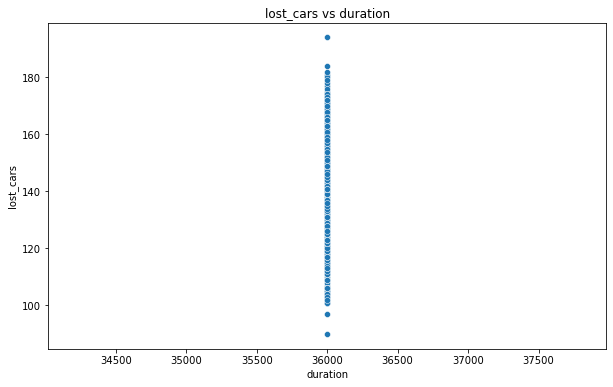

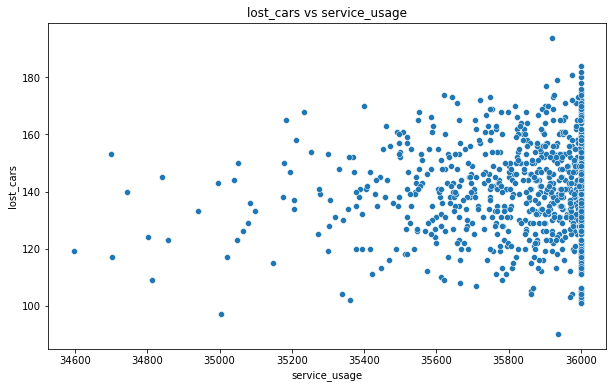

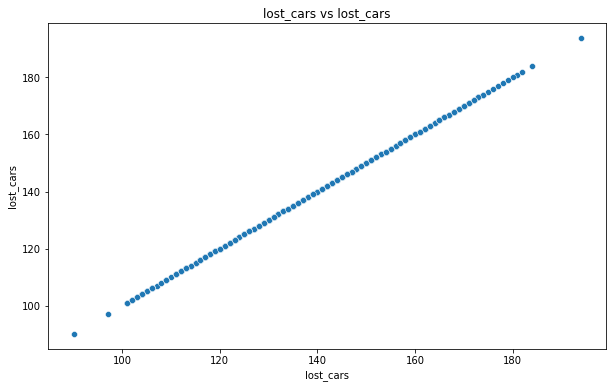

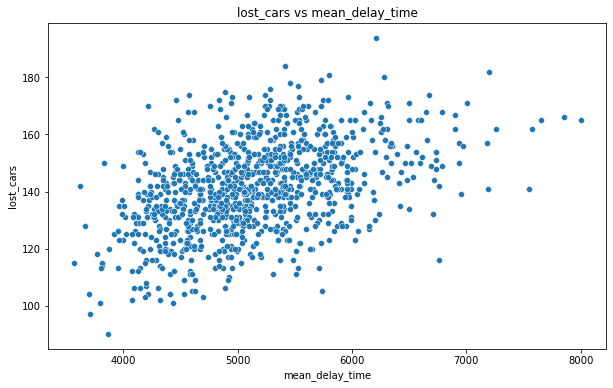

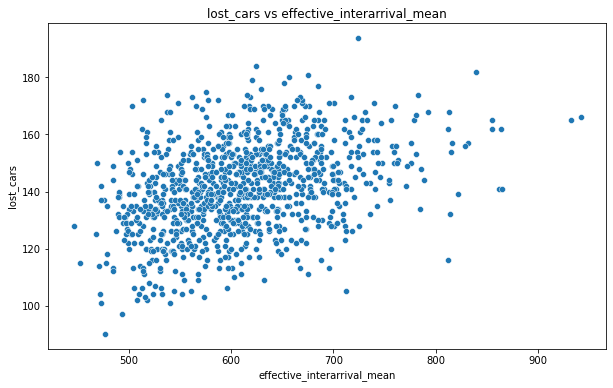

In [10]:
import seaborn as sns

# Identificar las columnas que terminan en "Minutes"

# Iterar sobre las columnas identificadas y generar un gráfico de puntos
for column in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=f'{column}', y='lost_cars', data=df)
    plt.title(f'lost_cars vs {column}')
    plt.show()

## Matriz de Correlación

Mediante la matriz de correlación veremos la relación entre las variables y nos dará una idea de las variables a seleccionar

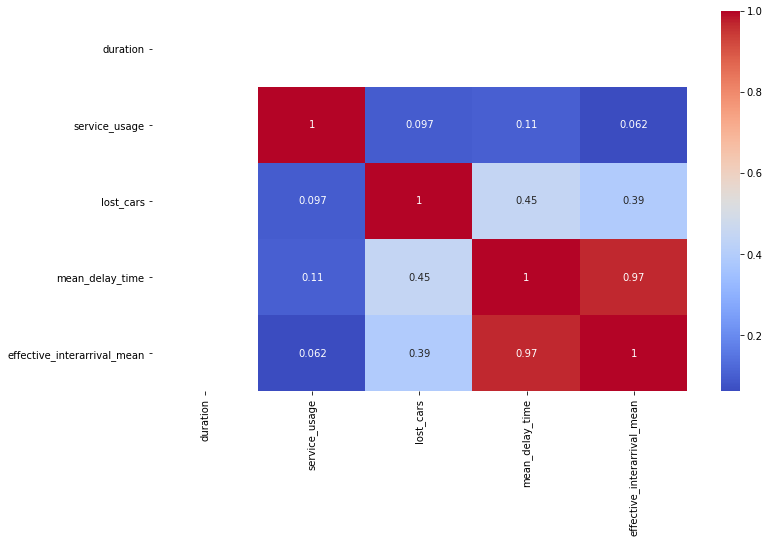

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()
# print(correlation_matrix)

fig, ax = plt.subplots(figsize=(12, 7)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


## Modelos de Regresion Lineal

### Modelo 1

Vamos a hacer el análisis con todas las variables para intentar predecir Calorías

In [16]:
from sklearn.model_selection import train_test_split

# Asumiendo que 'df' es tu DataFrame y que 'Calories' es la columna objetivo
X = df.drop('lost_cars', axis=1) # Variables independientes
X = X.drop('mean_delay_time', axis=1) # Variables independientes

y = df['lost_cars'] # Variable objetivo

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
import statsmodels.api as sm

# Añadir una constante a X para el modelo lineal
X_train = sm.add_constant(X_train)

# Crear y entrenar el modelo
model = sm.OLS(y_train, X_train).fit()

# Imprimir un resumen del modelo
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              lost_cars   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     74.89
Date:                Thu, 06 Jun 2024   Prob (F-statistic):           1.57e-30
Time:                        12:39:49   Log-Likelihood:                -3258.5
No. Observations:                 800   AIC:                             6523.
Df Residuals:                     797   BIC:                             6537.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
duration          

In [18]:
# Añadir una constante a X_test para el modelo lineal
X_test = sm.add_constant(X_test)

# Hacer predicciones con el modelo entrenado
predictions = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Error Cuadrático Medio: {mse}")
print(f"Coeficiente de Determinación R^2: {r2}")

Error Cuadrático Medio: 213.46631850338068
Coeficiente de Determinación R^2: 0.16846307241236758


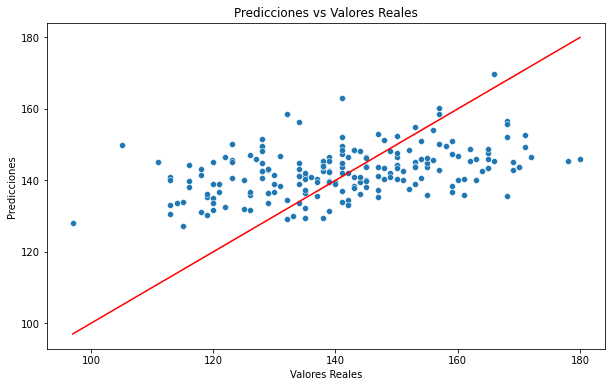

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que 'y_test' son los valores reales y 'predictions' son las predicciones del modelo
# Crear un DataFrame para facilitar la visualización
data = pd.DataFrame({'Real': y_test, 'Predicted': predictions})

# Crear un gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Real', y='Predicted', data=data)

# Añadir una línea de identidad para visualizar la alineación de las predicciones con los valores reales
sns.lineplot(x='Real', y='Real', data=data, color='red')

# Añadir títulos y etiquetas
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

# Mostrar el gráfico
plt.show()

Como observamos anteriormente en los resultados de **model.summary()** vemos que hay una variable cuyo $P > |t|$ es mayor que 0.05, lo cual indica que no es significativa en el modelo y puede llevar a errores en el resultado. Por lo que hagamos otro modelo pero esta vez eliminandola.

## Análisis de residuos

In [20]:
residuos = model.resid

In [21]:
import numpy as np

media_residuos = np.mean(residuos)
suma_residuos = np.sum(residuos)

print(f"Media de los residuos: {media_residuos}")

if np.isclose(media_residuos, 0):
    print("La media de los residuos es cero.")
else:
    print("La media de los residuos no es cero.")

print(f"Suma de los residuos: {suma_residuos}")

if np.isclose(suma_residuos, 0):
    print("La suma de los residuos es cero.")
else:
    print("La suma de los residuos no es cero.")


Media de los residuos: -1.0824408036569366e-12
La media de los residuos es cero.
Suma de los residuos: -8.658815886519733e-10
La suma de los residuos es cero.


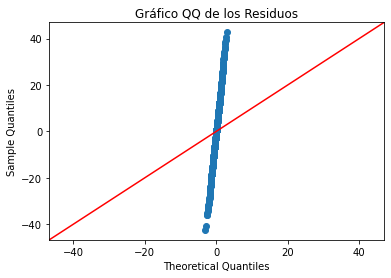

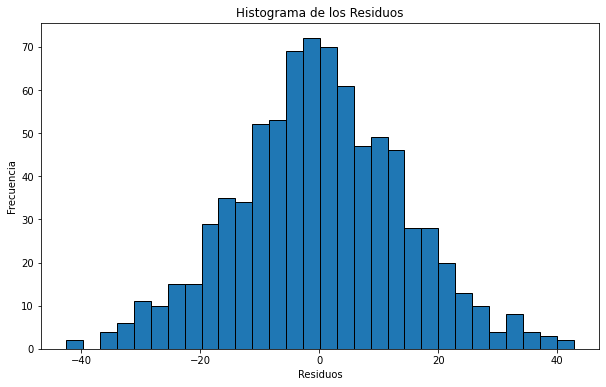

In [22]:
from scipy.stats import kstest

# Gráfico QQ de los residuos
fig = sm.qqplot(residuos, line='45')
plt.title('Gráfico QQ de los Residuos')
plt.show()

# Histograma de los residuos
plt.figure(figsize=(10, 6))
plt.hist(residuos, bins=30, edgecolor='k')
plt.title('Histograma de los Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.show()

Como vemos los residuos del modelo no siguen una distribución normal, esto puede tener varias implicaciones:

- Inferencias estadísticas: Muchos métodos estadísticos, incluyendo la regresión lineal y ANOVA, asumen que los residuos son normalmente distribuidos. Si esta suposición se viola, las inferencias estadísticas (como los intervalos de confianza y las pruebas de hipótesis) que se basan en el modelo pueden no ser válidas.
- Eficiencia del modelo: Un modelo con residuos no normales puede no ser el modelo más eficiente para los datos. Es posible que exista otro modelo que se ajuste mejor a estos.
- Violación de otros supuestos: Los residuos no normales a menudo indican que se están violando otros supuestos del modelo. Por ejemplo, podrían sugerir que la relación entre las variables no es lineal, o que la varianza de los residuos no es constante (heterocedasticidad).

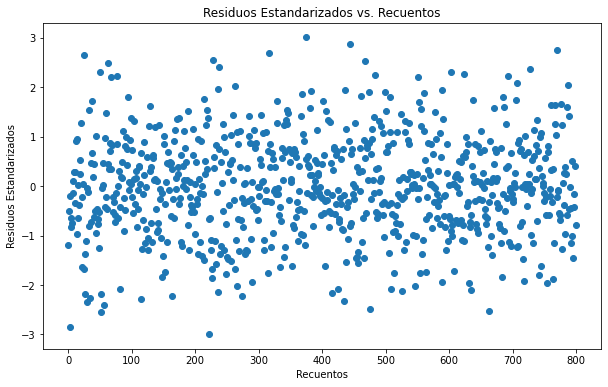

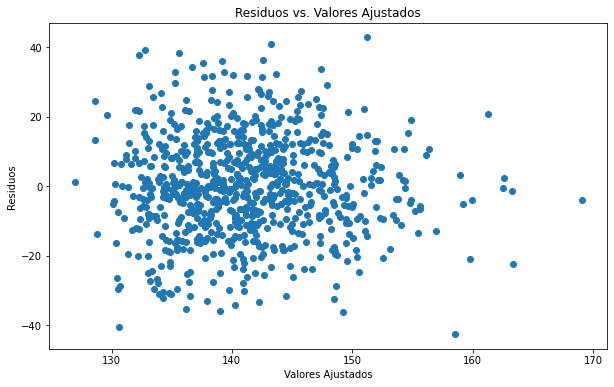

[('Lagrange multiplier statistic', 3.6345676921379244), ('p-value', 0.16246643602755476), ('f-value', 1.8187319119560432), ('f p-value', 0.16290400127885246)]


In [23]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

# Calcular los residuos estandarizados
residuos_estandarizados = residuos / np.std(residuos)

# Gráfico de residuos estandarizados contra recuentos
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuos_estandarizados)), residuos_estandarizados)
plt.title('Residuos Estandarizados vs. Recuentos')
plt.xlabel('Recuentos')
plt.ylabel('Residuos Estandarizados')
plt.show()

# Gráfico de residuos vs. valores ajustados
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, residuos)
plt.title('Residuos vs. Valores Ajustados')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.show()


# Realizar el test de Breusch-Pagan
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(model.resid, model.model.exog)

# Imprimir los resultados del test
print(lzip(names, test))

### Test de Kolmogorov-Smirnov

In [24]:
# Realizar la prueba del Kolmogorov-Smirnov para verificar la normalidad de los residuos
D, p_value = kstest(residuos, 'norm')

print(f"D = {D}, p-value = {p_value}")

if p_value > 0.05:
    print("Los residuos parecen estar normalmente distribuidos.")
else:
    print("Los residuos no parecen estar normalmente distribuidos.")

D = 0.42567028708513294, p-value = 4.675089208631274e-132
Los residuos no parecen estar normalmente distribuidos.


### Conclusiones de los residuos del modelo

Los residuos no están normalmente distribuidos

## PCA

Aplicando la técnica PCA (Principal Component Analysis) vamos a reducir la dimensionalidad de los datos

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Primero estandarizamos los datos para asegurarnos de que estaremos trabajando con datos en la misma escala

In [25]:
# Seleccionamos las variables que vamos a analizar
pca_data = df[['TotalSteps', 'TotalDistance', 'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'Calories']]


scaler = StandardScaler()
scaled_results = scaler.fit_transform(pca_data)

pca_data.columns 

NameError: name 'StandardScaler' is not defined

In [26]:
# Aplicando PCA
pca = PCA()
pca_results = pca.fit_transform(scaled_results)
print(pca_results)

NameError: name 'PCA' is not defined

A través del cálculo de la varianza explicada por cada componente nos da una idea acerca de cuánta variación es capturada por cada componente principal

Varianza explicada:
Componente principal 1: 43.04%
Componente principal 2: 23.60%
Componente principal 3: 19.78%
Componente principal 4: 8.19%
Componente principal 5: 2.81%
Componente principal 6: 1.60%
Componente principal 7: 0.74%
Componente principal 8: 0.20%
Componente principal 9: 0.03%

Varianza acumulada:
Hasta el componente principal 1: 43.04%
Hasta el componente principal 2: 66.65%
Hasta el componente principal 3: 86.42%
Hasta el componente principal 4: 94.61%
Hasta el componente principal 5: 97.43%
Hasta el componente principal 6: 99.02%
Hasta el componente principal 7: 99.77%
Hasta el componente principal 8: 99.97%
Hasta el componente principal 9: 100.00%


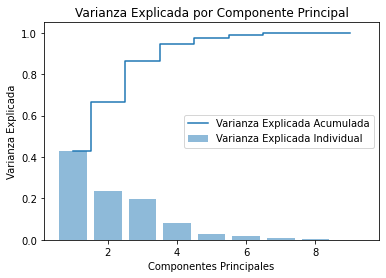

In [36]:
# Calcular la varianza explicada
explained_variance = pca.explained_variance_ratio_
acum_variance = np.cumsum(explained_variance)

print("Varianza explicada:")
for i, varianza in enumerate(explained_variance, start=1):
    print(f"Componente principal {i}: {varianza:.2%}")

print("\nVarianza acumulada:")
for i, varianza_acum in enumerate(acum_variance, start=1):
    print(f"Hasta el componente principal {i}: {varianza_acum:.2%}")

# Visualizar la varianza explicada
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Varianza Explicada Individual')
plt.step(range(1, len(explained_variance) + 1), acum_variance, where='mid', label='Varianza Explicada Acumulada')
plt.xlabel('Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.title('Varianza Explicada por Componente Principal')
plt.legend()
plt.show()

Como podemos observar, las componente a partir de la 3ra explican cada una menos del 10% de la varianza de los datos, por lo que para nuestro proyecto tomaremos solo 3 componentes, con lo cual estaríamos abarcando un 73.71% de los datos.

Se realiza un análisis de los componentes principales y para cada uno se identifican las características más importantes. Esto se hace tomando el valor absoluto de cada componente principal y seleccionando las características con los valores más altos. Esto es útil porque nos permite entender qué características contribuyen más a cada componente principal.


In [37]:
# Análisis de los componentes principales
principal_components = pd.DataFrame(pca.components_, columns=pca_data.columns)


# Identificar características más importantes para los primeros dos componentes principales
principal_component1 = principal_components.iloc[0]
principal_component2 = principal_components.iloc[1]
principal_component3 = principal_components.iloc[2]


# Valores maximos absolutos de cada componente
max1 = principal_component1.abs().nlargest(1).values
max2 = principal_component2.abs().nlargest(1).values
max3 = principal_component3.abs().nlargest(1).values


# Obtener las características más importantes para el primer componente principal (PC1)
pc1_characteristics = principal_component1.abs().nlargest(principal_component1.size).index
print("Las características más importantes para el componente principal (PC1) son:")
for i, characteristic in enumerate(pc1_characteristics, start=1):
    if abs(principal_component1[characteristic]) > max1/2:
        print(f"{i}. {characteristic}")


# Obtener las características más importantes para el segundo componente principal (PC2)
pc2_characteristics = principal_component2.abs().nlargest(principal_component2.size).index
print("\nLas características más importantes para el componente principal (PC2) son:")
for i, characteristic in enumerate(pc2_characteristics, start=1):
    if abs(principal_component2[characteristic]) > max2/2:
        print(f"{i}. {characteristic}")


# Obtener las características más importantes para el tercer componente principal (PC3)
pc3_characteristics = principal_component3.abs().nlargest(principal_component3.size).index
print("\nLas características más importantes para el componente principal (PC3) son:")
for i, characteristic in enumerate(pc3_characteristics, start=1):
    if abs(principal_component3[characteristic]) > max3/2:
        print(f"{i}. {characteristic}")



Las características más importantes para el componente principal (PC1) son:
1. TotalDistance
2. TotalSteps
3. VeryActiveDistance
4. VeryActiveMinutes
5. Calories
6. LightActiveDistance

Las características más importantes para el componente principal (PC2) son:
1. ModeratelyActiveDistance
2. LightlyActiveMinutes
3. FairlyActiveMinutes
4. LightActiveDistance
5. VeryActiveMinutes
6. VeryActiveDistance

Las características más importantes para el componente principal (PC3) son:
1. FairlyActiveMinutes
2. ModeratelyActiveDistance
3. LightlyActiveMinutes
4. LightActiveDistance


Realizamos un análisis de los componentes principales y se visualizamos la importancia de las características en cada componente principal a través de un mapa de calor.

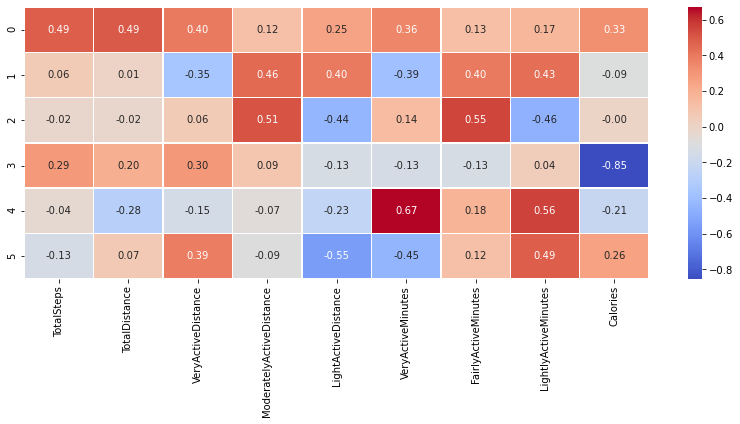

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una tabla de calor con seaborn
plt.figure(figsize=(14, 5)) 
sns.heatmap(principal_components[:6], cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)

# Mostrar la tabla de calor
plt.show()

## Modelo de Regresión lineal con las componentes principales

In [39]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [40]:
pca = PCA(n_components=3)  # Ajusta el número de componentes
X_pca = pca.fit_transform(pca_data)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [42]:
# model = LinearRegression()
# model.fit(X_train, y_train)

# predictions = model.predict(X_test)

import statsmodels.api as sm

# Añadir una constante a X para el modelo lineal
X_train = sm.add_constant(X_train)

# Crear y entrenar el modelo
model = sm.OLS(y_train, X_train).fit()

# Imprimir un resumen del modelo
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Calories   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.506e+08
Date:                Sun, 21 Apr 2024   Prob (F-statistic):               0.00
Time:                        01:14:56   Log-Likelihood:                -189.20
No. Observations:                 587   AIC:                             386.4
Df Residuals:                     583   BIC:                             403.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2582.8978      0.014   1.87e+05      0.0

Podemos ver que nos sigue diciendo el modelo que tenemos problemas de multicolinealidad, probamos usando varias componentes y con todas nos da los mismos resultados

In [43]:
# Añadir una constante a X_test para el modelo lineal
X_test = sm.add_constant(X_test)

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Error Cuadrático Medio: {mse}")
print(f"Coeficiente de Determinación R^2: {r2}")

Error Cuadrático Medio: 273388.28496488044
Coeficiente de Determinación R^2: 0.5379221405590743


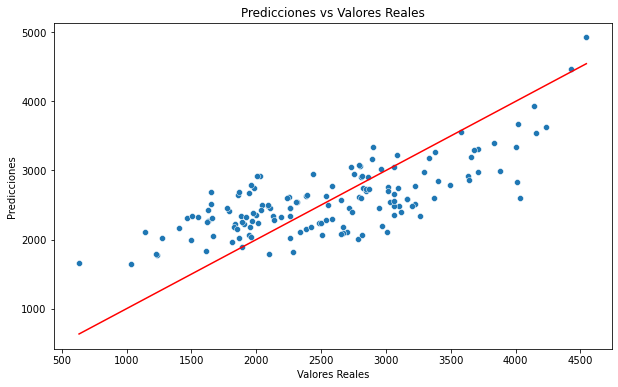

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que 'y_test' son los valores reales y 'predictions' son las predicciones del modelo
# Crear un DataFrame para facilitar la visualización
data = pd.DataFrame({'Real': y_test, 'Predicted': predictions})

# Crear un gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Real', y='Predicted', data=data)

# Añadir una línea de identidad para visualizar la alineación de las predicciones con los valores reales
sns.lineplot(x='Real', y='Real', data=data, color='red')

# Añadir títulos y etiquetas
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

# Mostrar el gráfico
plt.show()

## Análisis de residuos del modelo con las componentes principales

In [45]:
residuos = model.resid

In [46]:
import numpy as np

media_residuos = np.mean(residuos)
suma_residuos = np.sum(residuos)

print(f"Media de los residuos: {media_residuos}")

if np.isclose(media_residuos, 0):
    print("La media de los residuos es cero.")
else:
    print("La media de los residuos no es cero.")

print(f"Suma de los residuos: {suma_residuos}")

if np.isclose(suma_residuos, 0):
    print("La suma de los residuos es cero.")
else:
    print("La suma de los residuos no es cero.")


Media de los residuos: 4.880593374079598e-13
La media de los residuos es cero.
Suma de los residuos: 2.864908310584724e-10
La suma de los residuos es cero.


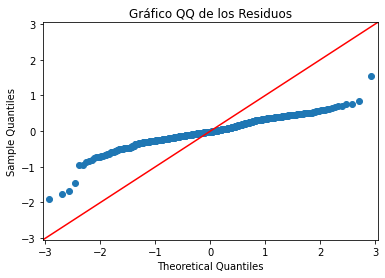

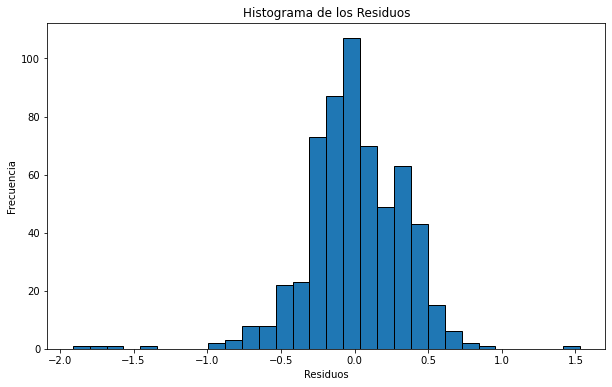

In [47]:
from scipy.stats import kstest

# Gráfico QQ de los residuos
fig = sm.qqplot(residuos, line='45')
plt.title('Gráfico QQ de los Residuos')
plt.show()

# Histograma de los residuos
plt.figure(figsize=(10, 6))
plt.hist(residuos, bins=30, edgecolor='k')
plt.title('Histograma de los Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.show()

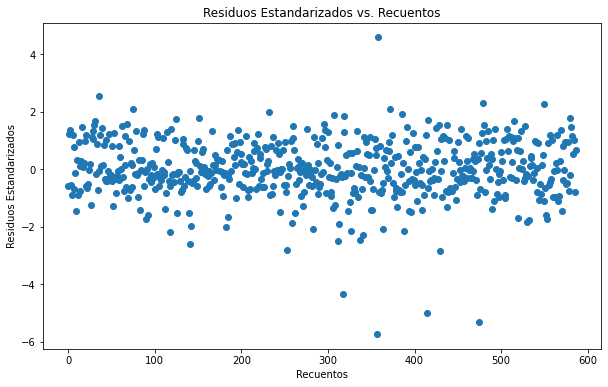

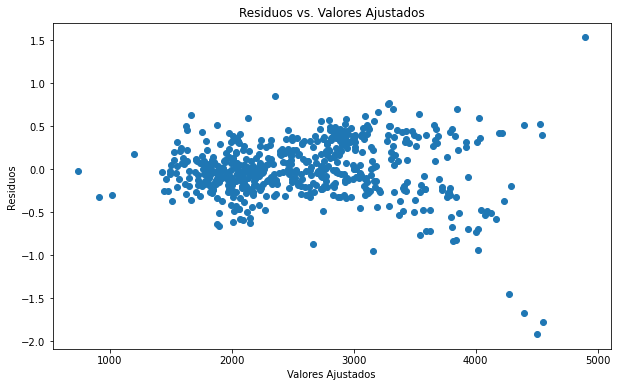

[('Lagrange multiplier statistic', 99.82741511717673), ('p-value', 1.692793973941889e-21), ('f-value', 39.82119466438668), ('f p-value', 2.0218950661413632e-23)]


In [48]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

# Calcular los residuos estandarizados
residuos_estandarizados = residuos / np.std(residuos)

# Gráfico de residuos estandarizados contra recuentos
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuos_estandarizados)), residuos_estandarizados)
plt.title('Residuos Estandarizados vs. Recuentos')
plt.xlabel('Recuentos')
plt.ylabel('Residuos Estandarizados')
plt.show()

# Gráfico de residuos vs. valores ajustados
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, residuos)
plt.title('Residuos vs. Valores Ajustados')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.show()


# Realizar el test de Breusch-Pagan
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(model.resid, model.model.exog)

# Imprimir los resultados del test
print(lzip(names, test))

In [49]:
# Realizar la prueba del Kolmogorov-Smirnov para verificar la normalidad de los residuos
D, p_value = kstest(residuos, 'norm')

print(f"D = {D}, p-value = {p_value}")

if p_value > 0.05:
    print("Los residuos parecen estar normalmente distribuidos.")
else:
    print("Los residuos no parecen estar normalmente distribuidos.")

D = 0.2741294480402667, p-value = 1.7926490920333244e-39
Los residuos no parecen estar normalmente distribuidos.
